<a href="https://colab.research.google.com/github/sudarshan-koirala/youtube-stuffs/blob/main/langchain/synthetic_data_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare the data in a definite format


In [1]:
def clean_subpart(input_list,input_list2):

    # Extract the single string from input list
    single_string = input_list


    # Split the single string by spaces
    split_string = single_string.split()

    # Create a list to hold formatted key-value pairs
    output_list = []

    # Initialize an empty string to build each formatted key-value pair
    current_pair = ""

    # Iterate through each item in the split_string
    for item in split_string:
        # If item ends with ':', it's the start of a new key
        if item.endswith(':'):
            # If there's a current pair being built, append it to output_list
            if current_pair:
                output_list.append(current_pair.strip())
            # Start a new key-value pair with the current item
            current_pair = item
        else:
            # Append current item to current pair with space separation
            current_pair += ' ' + item

    # Append the last current pair to output_list
    if current_pair:
        output_list.append(current_pair.strip())
        output_list.append(input_list2)

    # Print the output list of strings
    return output_list


In [2]:
import re


def clean_email(email_content):


    # Define a pattern to match the headers to be removed
    pattern = r"(Mime-Version|Content-Type|Content-Transfer-Encoding|Folder):[^\n]*\n"

    # Remove the headers using re.sub with an empty string replacement
    cleaned_email = re.sub(pattern, '', email_content)

    # Print the cleaned email content
    cleaned_email=cleaned_email.strip()
    cleaned_email=cleaned_email.replace('X-','')
    cleaned_email=cleaned_email.replace('Message-ID','MessageID')

    # Split the raw data into lines
    input_list = cleaned_email.strip().split("\n")


    # Initialize an empty list to store output
    output_list = []

    # Initialize a variable to hold concatenated lines
    current_line = ""

    # Iterate through each line in the input list
    for line in input_list:
        if line.strip() == "":
            # If line is empty, append the current concatenated line to output list
            if current_line:
                output_list.append(current_line.strip())
                current_line = ""
        else:
            # Concatenate non-empty lines into current_line
            current_line += " " + line.strip()

    # Append the last concatenated line if any
    if current_line:
        output_list.append(current_line.strip())


    # Separate the first element (header) and the rest (content)
    header = output_list[0]
    content = " ".join(output_list[1:])  # Join all lines except the first one with space

    # Create the output list
    output_list = [header, f"Message:{content.strip()}"]

    result=clean_subpart(output_list[0],output_list[1])
    return ','.join(result)



In [3]:
import pandas as pd
import re

df=pd.read_csv('/content/emails.csv')
# Apply the function to the 'message' column
df['clean_message'] = df['message'].apply(clean_email)

df.to_csv('/content/emails.csv',index=False)

new_df=df.iloc[:10]

### How Is it done ??
### Before GenAI emerged (Well, this is used still in many companies but **GenAI is what everyone is talking about these days** )
Some of the modelling techniques used:
- Classic statistical methods
- Deep Learning models (GAN , VAE behind the scene)
- Mix of classic statistical models and Deep Learning.

Once synthetic data is generated, we need to evaluate it to make sure it is OK to use in downstream tasks. There are many libraries, websites offering these kind of solutions. But here, we focus in GenAI part.

## Use case

Synthetic data refers to artificially generated data that imitates the characteristics of real data without containing any information from actual individuals or entities. It is typically created through mathematical models, algorithms, or other data generation techniques. Synthetic data can be used for a variety of purposes, including testing, research, and training machine learning models, while preserving privacy and security.

Benefits of Synthetic Data:

1. **Privacy and Security**: No real personal data at risk of breaches.
2. **Data Augmentation**: Expands datasets for machine learning.
3. **Flexibility**: Create specific or rare scenarios.
4. **Cost-effective**: Often cheaper than real-world data collection.
5. **Regulatory Compliance**: Helps navigate strict data protection laws.
6. **Model Robustness**: Can lead to better generalizing AI models.
7. **Rapid Prototyping**: Enables quick testing without real data.
8. **Controlled Experimentation**: Simulate specific conditions.
9. **Access to Data**: Alternative when real data isn't available.

**Note: Despite the benefits, synthetic data should be used carefully, as it may not always capture real-world complexities.**

## Quickstart

In this notebook, we'll dive deep into generating synthetic email data samples using the langchain library. This tool is particularly useful when you want to develop or test algorithms but don't want to use real patient data due to privacy concerns or data availability issues.

## Setup
- First, you'll need to have the langchain library installed, along with its dependencies. Since we're using the OpenAI generator chain, we'll install that as well. Since this is an experimental lib, we'll need to include `langchain_experimental` in our installs.
- [Pydantic](https://docs.pydantic.dev/latest/): Data validation library for Python

In [4]:
%%capture
!pip install -U langchain langchain_experimental openai

In [ ]:
# set environment variables
# https://platform.openai.com/account/api-keys
import os
os.environ["OPENAI_API_KEY"] = "openai key"

: 

In [6]:
from langchain.prompts import FewShotPromptTemplate, PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.pydantic_v1 import BaseModel
from langchain_experimental.tabular_synthetic_data.base import SyntheticDataGenerator
from langchain_experimental.tabular_synthetic_data.openai import create_openai_data_generator, OPENAI_TEMPLATE
from langchain_experimental.tabular_synthetic_data.prompts import SYNTHETIC_FEW_SHOT_SUFFIX, SYNTHETIC_FEW_SHOT_PREFIX

## 1. Define Your Data Model
- Every dataset has a structure or a "schema".
- The Emaildata class below serves as our schema for the synthetic data.
- By defining this, we're informing our synthetic data generator about the shape and nature of data we expect.

In [7]:
class Emaildata(BaseModel):
    MessageID:str
    Date: str
    From: str
    To: str
    Subject: str
    From:str
    To: str
    cc: str
    bcc: str
    Origin: str
    FileName: str
    Message:str


## 2. Sample Data
To guide the synthetic data generator, it's useful to provide it with a few real-world-like examples. These examples serve as a "seed" - they're representative of the kind of data you want, and the generator will use them to create more data that looks similar.

Here are some fictional email data samples:

In [8]:
# Create a list of dictionaries from 'message' column
examples = [{"example": msg} for msg in new_df['clean_message']]



## 3. Craft a Prompt Template
The generator doesn't magically know how to create our data; we need to guide it. We do this by creating a prompt template. This template helps instruct the underlying language model on how to produce synthetic data in the desired format.

In [9]:
OPENAI_TEMPLATE = PromptTemplate(input_variables=["example"], template="{example}")

prompt_template = FewShotPromptTemplate(
    prefix=SYNTHETIC_FEW_SHOT_PREFIX,
    examples=examples,
    suffix=SYNTHETIC_FEW_SHOT_SUFFIX,
    input_variables=["subject", "extra"],
    example_prompt=OPENAI_TEMPLATE,
)

The `FewShotPromptTemplate` includes:

- `prefix` and `suffix`: These likely contain guiding context or instructions.
- `examples`: The sample data we defined earlier.
- `input_variables`: These variables ("subject", "extra") are placeholders you can dynamically fill later. For instance, "subject" might be filled with "email_data" to guide the model further.
- `example_prompt`: This prompt template is the format we want each example row to take in our prompt.

## 4. Creating the Data Generator
With the schema and the prompt ready, the next step is to create the data generator. This object knows how to communicate with the underlying language model to get synthetic data.

This code initializes a synthetic data generator using the OpenAI API. It defines the output schema as Email_data, configures the language model instance with specified parameters such as temperature to control creativity, and assigns a prompt template to guide the data generation process.

In [10]:
synthetic_data_generator = create_openai_data_generator(
    output_schema=Emaildata,
    llm=ChatOpenAI(temperature=0),
    prompt=prompt_template,
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


## 5. Generate Synthetic Data
Finally, let's get our synthetic data!

In [18]:
synthetic_results = synthetic_data_generator.generate(
    subject="email_data",
    extra="every data should be different from each other and also it should be different from original data the name must be chosen at random. Make it something you wouldn't normally choose.",
    runs=10,
)

###This code generates 10 synthetic records adhering to the “email_data” schema, with additional instructions that semantic meaning must be same

## 6. Converting the synthetic data into Pandas Dataframe

In [20]:
import pandas as pd

# Create a list of dictionaries from the objects
synthetic_data = []
for item in synthetic_results:
    synthetic_data.append({
        'MessageID':item.MessageID,
        'Date': item.Date,
    'From': item.From,
    'To': item.To,
    'Subject': item.Subject,
    'From':item.From,
    'To': item.To,
    'cc': item.cc,
    'bcc': item.bcc,
    'Origin': item.Origin,
    'FileName': item.FileName,
    'Message':item.Message,
    })

# Create a Pandas DataFrame from the list of dictionaries
synthetic_df = pd.DataFrame(synthetic_data)

# Display the DataFrame
print(type(synthetic_df))
synthetic_df=synthetic_df.iloc[10:]
synthetic_df.to_csv('/content/synthetic_data.csv',index=False)

<class 'pandas.core.frame.DataFrame'>


##**Combined Code**

##Combining all the code into a function so that it can iterate over all the samples of enron data and generate 10 samples of data each time

In [21]:
def data_generator(new_df,start_idx):
  # Create a list of dictionaries from 'message' column
  examples = [{"example": msg} for msg in new_df['clean_message']]
  OPENAI_TEMPLATE = PromptTemplate(input_variables=["example"], template="{example}")

  prompt_template = FewShotPromptTemplate(
      prefix=SYNTHETIC_FEW_SHOT_PREFIX,
      examples=examples,
      suffix=SYNTHETIC_FEW_SHOT_SUFFIX,
      input_variables=["subject", "extra"],
      example_prompt=OPENAI_TEMPLATE,
  )

  synthetic_data_generator = create_openai_data_generator(
    output_schema=Emaildata,
    llm=ChatOpenAI(temperature=0),
    prompt=prompt_template,
  )

  synthetic_results = synthetic_data_generator.generate(
    subject="email_data",
    extra="every data should be different from each other and also it should be different from original data the name must be chosen at random. Make it something you wouldn't normally choose.",
    runs=10,
)

  # Create a list of dictionaries from the objects
  synthetic_data = []
  for item in synthetic_results:
      synthetic_data.append({
          'MessageID':item.MessageID,
          'Date': item.Date,
      'From': item.From,
      'To': item.To,
      'Subject': item.Subject,
      'From':item.From,
      'To': item.To,
      'cc': item.cc,
      'bcc': item.bcc,
      'Origin': item.Origin,
      'FileName': item.FileName,
      'Message':item.Message,
      })

  # Create a Pandas DataFrame from the list of dictionaries
  synthetic_df = pd.DataFrame(synthetic_data)

  # Display the DataFrame
  synthetic_df.to_csv(f'/content/synthetic_data_{start_idx}.csv',index=False)




df=pd.read_csv('/content/emails.csv')
chunk_size=10
  # Loop through the dataframe in chunks
for start_idx in range(0, len(df), chunk_size):
    # Extract chunk
    chunk = df.iloc[start_idx:start_idx + chunk_size]
    data_generator(chunk,start_idx)

KeyboardInterrupt: 

### Start exploring based on your usecase and use the same approach for real sensitive data. But, be careful, as the synthetic data might not capture the real-world complexities.

##Now do data analysis i.e. how similar is generated dataset from original dataset

In [ ]:
# Initialize an empty list to store DataFrames
dfs = []

# Assuming df is your original DataFrame from which you iterate
for index, row in df.iterrows():
    # Split the clean_message by ','
    data_list = row['clean_message'].split(',')
    data_dict = {}

    # Parse each line in the data_list
    for line in data_list:
        # Split the line at the first occurrence of ':'
        key_value = line.split(':', 1)

        # Check if the split resulted in two parts
        if len(key_value) == 2:
            key = key_value[0].strip()  # Column name (remove leading/trailing spaces)
            value = key_value[1].strip()  # Value (remove leading/trailing spaces)
            data_dict[key] = value
        else:
            # Handle lines without ':' (if any)
            key = key_value[0].strip()
            data_dict[key] = ''  # Empty value for lines without ':' (like 'Subject:')

    # Create a consistent set of columns
    columns = ['MessageID', 'Date', 'From', 'To', 'Subject', 'cc', 'bcc', 'Origin',
       'FileName', 'Message']

    # Create DataFrame from dictionary and ensure consistent columns
    a = pd.DataFrame([data_dict], columns=columns)
    dfs.append(a)

# Concatenate all DataFrames in the list
original_df = pd.concat(dfs, ignore_index=True)

# Print the resulting DataFrame
#print(original_df)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import seaborn as sns



##**Word Cloud**

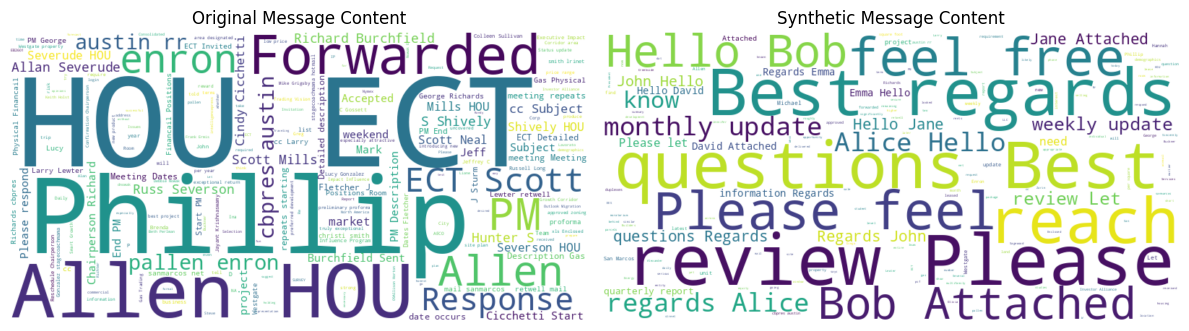

In [ ]:
# Generate word clouds for each text column
text1 = ' '.join(original_df['Message'])
text2 = ' '.join(synthetic_df['Message'])

wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate(text1)
wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate(text2)

# Plot word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.title('Original Message Content')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.title('Synthetic Message Content')
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
!pip install sentence_transformers

###Range of Values:

Cosine similarity values range from -1 to 1.
Values close to 1 indicate that the texts are very similar.
Values close to 0 indicate that the texts are dissimilar.
Negative values (though less common in text similarity tasks) indicate an inverse or opposite relationship between texts.

##Interpreting Specific Values:

1.0: The texts are identical.
0.9 to 1.0: The texts are very similar.
0.7 to 0.9: The texts are somewhat similar.
0.5 to 0.7: The texts are moderately similar.
0.3 to 0.5: The texts are less similar.
0.0 to 0.3: The texts are dissimilar.
Negative values: There is a negative relationship between the texts (very rare in text similarity tasks).

In [ ]:
from sentence_transformers import SentenceTransformer

# Load pre-trained model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Encode sentences
embeddings1 = model.encode(original_df['Message'].tolist())
embeddings2 = model.encode(synthetic_df['Message'].tolist())

# Compute cosine similarity between embeddings
semantic_similarity = cosine_similarity(embeddings1, embeddings2)

print("Semantic Similarity Matrix:")
print(semantic_similarity)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Semantic Similarity Matrix:
[[ 0.12277119  0.36193174  0.36193174  0.36193174  0.36193174  0.36193174
   0.36193174  0.36193174  0.18702245  0.353451  ]
 [-0.01509899  0.05519317  0.05519317  0.05519317  0.05519317  0.05519317
   0.05519317  0.05519317  0.02185882  0.00153279]
 [-0.10370359  0.05740009  0.05740009  0.05740009  0.05740009  0.05740009
   0.05740009  0.05740009  0.00153996  0.0535405 ]
 [ 0.16003352  0.19127542  0.19127542  0.19127542  0.19127542  0.19127542
   0.19127542  0.19127542  0.26259762  0.22451478]
 [ 0.01746615  0.14213264  0.14213264  0.14213264  0.14213264  0.14213264
   0.14213264  0.14213264  0.20155993  0.14474155]
 [ 0.27784544  0.30794367  0.30794367  0.30794367  0.30794367  0.30794367
   0.30794367  0.30794367  0.33592856  0.32995653]
 [ 0.32224476  0.31714985  0.31714985  0.31714985  0.31714985  0.31714985
   0.31714985  0.31714985  0.39559597  0.34687802]
 [ 0.03433165  0.23966515  0.23966515  0.23966515  0.23966515  0.23966515
   0.23966515  0.239665

In [ ]:
# Plotting heatmap of cosine similarity matrix
plt.figure(figsize=(100, 100))
sns.heatmap(semantic_similarity, cmap='YlGnBu', annot=True, vmin=0, vmax=1,
            xticklabels=synthetic_df['Message'], yticklabels=original_df['Message'])
plt.title('Semantic Similarity Matrix')
plt.xlabel('Synthetic Message Content')
plt.ylabel('Original Message Content')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.draw()
<ipython-input-43-0563ed4ba2ca>:10: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
